# Heatmapping Notebook

The purpose of this notebook is to create heatmap 'slices' to get a better sense of the shape of the temperature data.

#### Imports and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import random

from sklearn.linear_model import Lasso, LinearRegression as LR
from sklearn.linear_model import Ridge

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.preprocessing import StandardScaler as SS

from sklearn.model_selection import train_test_split as tts

from IPython.display import clear_output
from datetime import datetime as dt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from scipy.stats import ks_2samp
from scipy.stats import wasserstein_distance


In [2]:

def GetColors(N, cmap_name='rainbow'):
    from matplotlib.cm import get_cmap
    import numpy as np

    cmap = get_cmap(name=cmap_name)
    n = np.linspace(0,1,N)
    return cmap(n)

def PlotGroups(points, groups, colors):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6,6))

    for i, yi in enumerate(np.unique(groups)):
        idx = (groups == yi)
        plt.scatter(points[idx, 0], points[idx, 1],
                    alpha=0.5, ec='k', color=colors[i], label = yi)
    plt.axis('equal')
    plt.legend(loc='center left', bbox_to_anchor=[1, 0.5])
    #plt.show()
    return

def CompareClasses(actual, predicted, names=None):
    classes = pd.DataFrame(columns=['Predicted','Actual'])
    classes['Predicted'] = predicted
    classes['Actual'] = actual

    conf_mat = pd.crosstab(columns=classes['Predicted'],
                       index = classes['Actual'])
    if names != None:
        conf_mat.columns = names
        conf_mat.index = names

    conf_mat.columns.name = 'Predicted'
    conf_mat.index.name = 'Actual'

    accuracy = sum(predicted==actual)/len(actual)

    return conf_mat, accuracy

def DoKFold(model, X, y, k, scaler=None):
    from sklearn.model_selection import KFold
    import pandas as pd

    kf = KFold(n_splits=k, shuffle=True)

    if type(X) == pd.core.frame.DataFrame:
        X = X.values

    training_scores=[]
    testing_scores=[]

    for idxTrain, idxTest in kf.split(X):
        Xtrain = X[idxTrain,:]
        Xtest = X[idxTest,:]
        ytrain = y[idxTrain]
        ytest = y[idxTest]

        if scaler != None:
            # For standardization:
            # Fit/transform on training data
            Xtrain = scaler.fit_transform(Xtrain)
            #
            # Only transform (i.e, don't refit) on test data
            Xtest = scaler.transform(Xtest)

        model.fit(Xtrain,ytrain)

        training_scores.append(model.score(Xtrain,ytrain))
        testing_scores.append(model.score(Xtest,ytest))

    return training_scores, testing_scores

def plot_train_test(train, test, width, x_lab = None, y_lab = 'Mean Accuracy'):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,8))
    plt.plot(width, train, '-kx')
    plt.plot(width, test, '-rx')
    plt.legend()
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.show()


### Model simulation code


In [3]:
from math import sqrt
from array import *
import numpy as np
import matplotlib.pyplot as plt



from datetime import datetime as dt
import pandas as pd

In [4]:
def sutherland(T):
    """
    This function uses Sutherlands law to return dynamic viscosity for air as a function of temperature.
    Source: White, Viscous Fluid Flow, 3rd Edition Section 1-3.7

    Inputs
    ------
    T : float
        Temperature of air [K]

    Outputs
    -------
    mu : float
        Dynamic viscosity of air [N*s/m^2]

    Other Parameters
    ----------------
    T_ref: float
        Reference temperature of air [K]
    mu_ref: float
        Reference dynamic viscosity of air [N*s/m^2]
    S: float
        Sutherland constant for air [K]
    """

    # Reference Conditions for Air (From White Section 1-3.7 Table 1-2)
    T_ref = 273.0       # [K]
    mu_ref = 1.716e-5   # [N*s/m^2]
    S = 111.0           # [K]

    # Sutherland's Formula (White Section 1-3.7) (Note White uses T_0, mu_0 instead of T_ref, mu_ref)
    mu = mu_ref * ( (T/T_ref)**(3.0/2.0) * (T_ref + S)/(T + S) ) # [N*s/m^2]



    k_0 = 0.0241
    T_0 = 273 # [K]
    S_k = 194


    k = k_0 * ( (T/T_0)**(3.0/2.0) * (T_0 + S_k)/(T + S_k) ) # [W/(m*K)]

    return [mu, k]


In [5]:
def q_wall_fun(Tw, state, otherStuff):

    emissivity = otherStuff[0]
    M_inf = otherStuff[1]       # Freestream Mach number
    p_inf = otherStuff[2]       # Freestream pressure [Pa]
    T_inf = otherStuff[3]       # Freestream temperature [K]
    fudge_factor = otherStuff[4]

    edgeFlow = flowState()
    edgeFlow.fillMPT(M_inf, p_inf, T_inf)
    edgeFlow.state = state
    #edgeFlow.state = 'lam'
    #edgeFlow.state = 'turb'

    L = 1

    #Tw = 300      # Wall temperature [K]

    #f = lambda x: qwFun(x, edgeFlow, L, fudge_factor) - qradFun(x,emissivity)
    #Tw = bisection(f,100,2000,100)

    [qconv, Rex, Nu, Taw] = qwFun(Tw, edgeFlow, L, fudge_factor)
    qrad = qradFun(Tw,emissivity)

    #print("Tw = ", Tw)
    #print("qconv = ", qconv)
    #print("qrad = ", qrad)
    #print("Rex = ", Rex)
    #print("Nu = ", Nu)
    #print("Taw = ", Taw)

    qWall = qconv - qrad

 #   print("===")
 #   print("Tw = ", Tw)
 #   print("qWall = ", qWall)
 #   print("===")

    return qWall


def qradFun(Tw,emissivity):
    #emissivity = 0.8
    sigma = 5.6703e-8
    qrad = emissivity * sigma * Tw**4
    return qrad


def qwFun(Tw, edge, x, fudge_factor):
    """
    This function computes the convective heat flux for a flat plate.

    Inputs
    ------
    Tw : float
        Wall temperature [K]
    edge : flowState
        flowState at the edge of the boundary layer
    x : float
        Running length along the surface [m]

    Outputs
    -------
    qw : float
        Convective heat flux at the wall [W/m^2]
    """

    r = recoveryFactorFun(edge.Pr, edge.state)

    Taw = adiabaticWallTempFun(r, edge.T, edge.T0)

    Rex_e = edge.rho * edge.u * x / edge.mu



    if edge.state == 'lam':

        #T_star = edge.T * (0.5 + 0.039 * edge.M**2.0 + 0.5 * (Tw / edge.T))
        #CR_star = (T_star / edge.T)**(-1.0/3.0)
        #Rex_e = edge.rho * edge.u * x / edge.mu
        #cf = 0.664 * sqrt(CR_star) / sqrt(Rex_e)
        #ch = cf / (2.0 * edge.Pr**(2.0/3.0))
        #qw = ch * edge.rho * edge.u * edge.cp * (Taw - Tw)

        a = 0.332 # 0.453
        Nu = a * Rex_e**0.5*edge.Pr**(1.0/3.0)
        h = Nu*edge.k/x
        qw = h * (Taw - Tw)
        qw = qw * fudge_factor

    elif edge.state == 'turb':
        Nu = 0.0296 * Rex_e**0.8 * edge.Pr**0.6
        h = Nu*edge.k/x
        qw = h * (Taw - Tw)
        qw = qw * fudge_factor
    else:
        print('error')




    return [qw, Rex_e, Nu, Taw]

def edgeStateFun(M_inf, p_inf, T_inf):
    """
    This function computes a state vector of the flow properties at the edge of the boundary layer for a flat plate given the freestream conditions.

    Inputs
    ------
    M_inf : float
        Freestream Mach number

    p_inf : float
        Freestream pressure [Pa]

    T_inf : float
        Freestream temperature [K]

    Outputs
    ------
    edge : flowState
        flowState at the edge of the boundary layer
    """

    edge = flowState()

    edge.M = M_inf
    edge.p = p_inf
    edge.T = T_inf

    gamma_e = 1.4
    edge.cp = 1006.0 # [J/kg*K]
    R_e = 287.0 # [J/kg*K]

    a_e = sqrt(gamma_e * R_e * edge.T) # [m/s]
    edge.u = edge.M * a_e # [m/s]
    edge.rho = edge.p / (R_e * edge.T) # [kg/m^3]

    edge.mu = sutherland(edge.T)

    edge.T0 = edge.T + edge.u**2.0 / (2.0 * edge.cp)


    return edge

def recoveryFactorFun(Pr, flowState):
    """
    This function returns the recovery factor given the Prandtl number and the flow state (either laminar or turbulent).
    White, Viscous Fluid Flow, 3rd Edition Sections 7-3.1 and 7-8.3

    Inputs
    ------
    Pr : float
        Prandtl number

    flowState : str
        State of the flow: 'lam' for laminar or 'turb' for turbulent

    Outputs
    -------
    r : float
        Recovery factor
    """


    if flowState == 'lam':
        r = Pr**(0.5)   # White, Eq 7-37a in Section 7-3.1
    elif flowState == 'turb':
        r = Pr**(1.0/3.0) # White, Eq 7-136 in Section 7-8.3
    else:
        print('error')

    return r

def adiabaticWallTempFun(r, T_e, T0_e):
    """
    This function computes the adiabatic wall temperature given the recovery factor and static and total temperatures at the edge of the boundary layer.
    Source: White, Viscous Fluid Flow, 3rd Edition, Section 7-1.2

    Inputs
    ------
    r : float
        Recovery factor
    T_e : float
        Temperatures at the edge of the boundary layer [K]
    T0_e : float
        Total temperatures at the edge of the boundary layer [K]

    Outputs
    -------
    Taw : float
        Adiabatic wall temperature [K]
    """

    Taw = T_e + r * (T0_e - T_e) # White, Eq 7-16

    return Taw

class flowState:
    """
    This class represents the state variables at a point in a flow field.

    Attributes
    ----------
    M : float
        Mach number
    p : float
        Pressure [Pa]
    T : float
        Temperature [K]
    rho : float
        Density [kg/m^3]
    u : float
        Velocity magnitude [m/s]
    a : float
        Speed of sound [m/s]
    T0 : float
        Total temperature [K]
    p0 : float
        Total pressure [Pa]
    gamma : float
        Ratio of specific heats
    R : float
        Gas constant for air [J/kg*K]
    cp : float
        Specific heat at constant pressure [J/kg*K]
    mu : float
        Dynamic viscosity [N*s/m^2]
    Pr : float
        Prandtl number
    state : str
        State of the flow: 'lam' for laminar or 'turb' for turbulent

    Methods
    -------
    fillMPT(M, p, T)
        Fills the flow state using M, p, and T
    """

    def __init__(self):
        self.M      = []
        self.p      = []
        self.T      = []
        self.rho    = []
        self.u      = []
        self.a      = []
        self.q      = []
        self.p0     = []
        self.T0     = []
        self.gamma  = 1.4
        self.R      = 287.0     # [J/kg*K]
        self.cp     = 1004.5    # [J/kg*K]
        self.mu     = []
        self.k      = []
        self.Pr     = 0.72
        self.state  = []

    def fillMPT(self, M, p, T):
        """
        This method uses Mach, pressure, and temperature, along with the pre-defined thermodynamic states variables (gamma and R), to fill in most of the remaining flow state variables.
        """

        self.M = M
        self.p = p
        self.T = T

        self.a = sqrt(self.gamma * self.R * T) # [m/s]
        self.u = M * self.a # [m/s]
        self.rho = p / (self.R * T) # [kg/m^3]

        self.q = 0.5 * self.rho * self.u**2 #[Pa]

        [self.mu, self.k] = sutherland(T)

        self.T0 = T * (1.0 + 0.5*(self.gamma-1)*M**2)
        self.p0 = p * (1.0 + 0.5*(self.gamma-1)*M**2)**(self.gamma/(self.gamma-1))

In [6]:
def conductionFun(x_input, state, t_final):

    h_tile  = x_input[0]
    h_Ti    = x_input[1]

    rho_tile    = x_input[2]
    rho_Ti      = x_input[3]
    cp_tile     = x_input[4]
    cp_Ti       = x_input[5]
    k_tile      = x_input[6]
    k_Ti        = x_input[7]

    otherInputs = x_input[8:13]

    tps = TPSElement()

    #--- Outer BC ---
    #tps.OuterBCType = "fixedTemp"
    tps.OuterBCType = "fixedQ"
    #tps.TOuter = 600.0 # [K]
    #tps.qOuter = 141172.0 # [W/(m^2)]

    #--- Outer BC ---
    tps.InnerBCType = "insulated"
    tps.qInner = 0.0 # [W/(m^2)]

    #--- Initial Temperature ---
    tps.T0 = 300 # [K]

    #--- Define TPS Layrs ---
    #tps.layerThickness      = [0.0001, 0.007, 0.0001, 4*0.0254, 0.00015] #[m]
    #tps.rhoList             = [7117, 132, 7117, 96, 4437]                #[kg/m^3]
    #tps.cpList              = [625, 625, 625, 1150, 700]                 #[J/kg*K]
    #tps.kList               = [18, 0.35, 18, 0.05, 13]                   #[W/mK]
    #tps.nGridCellsPerLayer  = [4, 4, 4, 4, 4]

    tps.layerThickness      = [h_tile, h_Ti]   #[m]
    tps.rhoList             = [rho_tile, rho_Ti]           #[kg/m^3]
    tps.cpList              = [cp_tile, cp_Ti]            #[J/kg*K]
    tps.kList               = [k_tile, k_Ti]          #[W/mK]
    tps.nGridCellsPerLayer  = [50, 20]

    #tps.layerThickness      = [0.65*0.0254]   #[m]
    #tps.rhoList             = [144]           #[kg/m^3]
    #tps.cpList              = [628]            #[J/kg*K]
    #tps.kList               = [0.126]          #[W/mK]
    #tps.nGridCellsPerLayer  = [400]



    #--- Initialize the TPS Element ---
    tps.initializeTPS()
    tps.qOuter = q_wall_fun(tps.T[0], state, otherInputs)


#    print("==================================")
#    print("   time = ", tps.time)
#    print("==================================")
#    print("nLayers              = ", tps.nLayers)
#    print("nGridCellsPerLayer   = ", tps.nGridCellsPerLayer)
#    print("nGridCells           = ", tps.nGridCells)
#    print("delta_yPerLayer      = ", tps.delta_yPerLayer)
#    print("T[0]                 = ", tps.T[0])
#    print("T[end]               = ", tps.T[-1])
#    print("qOuter               = ", tps.qOuter)
    #print("delta_y              = ", tps.delta_y)
    #print("rho                  = ", tps.rho)
    #print("cp                   = ", tps.cp)
    #print("k                    = ", tps.k)
    #print("M = ")
    #print(tps.M)
    #print("T_RHS = ")
    #print(tps.T_RHS)

    delta_t = 0.1
    #tps.advance(delta_t)

    #t_final = 600

    for i in range(int(t_final/delta_t)):
        tps.advance(delta_t)
        tps.qOuter = q_wall_fun(tps.T[0], state, otherInputs)
        #print("Twall        = ", tps.T[0])

#    print(" ")
#    print("==================================")
#    print("   time = ", tps.time)
#    print("==================================")
#    print("qOuter       = ", tps.qOuter)
#    print("Twall        = ", tps.T[0])
#    print("T_Ti_outer   = ", tps.T[tps.nGridCellsPerLayer[0]])
#    print("T_Ti_inner   = ", tps.T[-1])
    #print("T = ", tps.T)

    return tps.T[tps.nGridCellsPerLayer[0]]

class TPSElement:
    """

    """

    def __init__(self):
        self.OuterBCType        = []
        self.InnerBCType        = []
        self.TOuter             = []
        self.TInner             = []
        self.qOuter             = []
        self.qInner             = []

        self.t0                 = 0.0       # Initial time
        self.time               = self.t0   # Time

        self.T0                 = []    # Initial temperature
        self.T                  = []    # Temperature

        self.y                  = []
        self.delta_y            = []
        self.delta_yPerLayer    = []

        self.nGridCellsPerLayer = []
        self.nGridCells         = []
        self.nLayers            = []
        self.layerThickness     = []

        self.rhoList            = []
        self.cpList             = []
        self.kList              = []

        self.rho                = []
        self.cp                 = []
        self.k                  = []

        self.M                  = []
        self.T_RHS              = []

    def initializeTPS(self):
        self.nLayers = len(self.layerThickness)

        self.nGridCells = 0
        for i in range(self.nLayers):
            self.nGridCells = self.nGridCells + self.nGridCellsPerLayer[i]

        self.delta_yPerLayer = [0] * self.nLayers
        for i in range(self.nLayers):
            self.delta_yPerLayer[i] = self.layerThickness[i] / self.nGridCellsPerLayer[i]

        self.T = [self.T0] * self.nGridCells

        self.delta_y = [0] * self.nGridCells
        self.rho     = [0] * self.nGridCells
        self.cp      = [0] * self.nGridCells
        self.k       = [0] * self.nGridCells

        counter = 0
        for i in range(self.nLayers):
            for j in range(self.nGridCellsPerLayer[i]):
                self.delta_y[counter]   = self.delta_yPerLayer[i]
                self.rho[counter]       = self.rhoList[i]
                self.cp[counter]        = self.cpList[i]
                self.k[counter]         = self.kList[i]
                counter = counter + 1

        self.M = np.empty(shape=(self.nGridCells,self.nGridCells))
        self.M.fill(0)

        self.T_RHS = np.empty(shape=(self.nGridCells,1))
        self.T_RHS.fill(0)

    def advance(self, delta_t):
        self.time = self.time + delta_t


        self.M[0][0] = -self.B(1)-self.A(0,delta_t)
        self.M[0][1] = self.B(1)
        self.T_RHS[0] = -self.A(0,delta_t) * self.T[0] - self.qOuter

        for i in range(1,self.nGridCells-1):
            self.M[i][i-1]   = self.B(i)
            self.M[i][i]     = -self.B(i) - self.B(i+1) - self.A(i,delta_t)
            self.M[i][i+1]   = self.B(i+1)
            self.T_RHS[i]    = -self.A(i,delta_t) * self.T[i]

        i_end = self.nGridCells - 1
        self.M[-1][-2] = self.B(i_end)
        self.M[-1][-1] = -self.B(i_end) - self.A(i_end,delta_t)
        self.T_RHS[-1] = -self.A(i_end,delta_t) * self.T[i_end] + self.qInner

        T_LHS = np.matmul(np.linalg.inv(self.M), self.T_RHS)

        self.T = list(T_LHS.flatten())

    def A(self, i, delta_t):

        A = self.rho[i] * self.cp[i] * self.delta_y[i] / delta_t

        return A

    def B(self, i):

        delta_y_avg = 0.5 * (self.delta_y[i] + self.delta_y[i-1])
        k_avg = (self.delta_y[i] * self.k[i] + self.delta_y[i-1] * self.k[i-1]) / (2.0 * delta_y_avg)

        B = k_avg / delta_y_avg

        return B


In [7]:
t_final     = 60    # [sec]

h_tile      = 0.0254     # [m]
h_Ti        = 0.00015    # [m]

rho_tile    = 144   # [kg/m^3]
rho_Ti      = 4540  # [kg/m^3]
cp_tile     = 628   # [J/kg*K]
cp_Ti       = 460   # [J/kg*K]
k_tile      = 0.126 # [W/mK]
k_Ti        = 7.1   # [W/mK]

emissivity  = 0.8

M_inf = 5.0     # Freestream Mach number
p_inf = 2736.0  # Freestream pressure [Pa]
T_inf = 284.0   # Freestream temperature [K]

fudge_factor = 1.0

x_input = [h_tile, h_Ti, rho_tile, rho_Ti, cp_tile, cp_Ti, k_tile, k_Ti,emissivity, M_inf, p_inf, T_inf, fudge_factor]

In [8]:
def run_model(x_input,t_final):
    T_Ti = conductionFun(x_input, 'turb', t_final)

    return T_Ti

Making the grid

In [9]:
import itertools

def expand_grid(data_dict):
    """Create a dataframe from every combination of given values."""
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

In [10]:
def ten_percent_bounds(number):
  lowerbound = number - 0.1*number
  upperbound = number + 0.1*number
  return lowerbound,upperbound

## Get_heatmap (regular)

In [11]:
def get_heatmap(var1,var2):
  """
  This function takes two variables in the run_model equation and creates a heatmap grid from -10% to +10% of the baseline value.

  Example:
  var1 = h_tile
  var2 = ?

  """
  n = 25 # n x n grid

  var1 = str(var1)
  print('var1 = ' + var1)

  var2 = str(var2)
  print('var2 = ' + var2)

  # -----
  # Setting the mean value of var1 and var2
  # -----

  base_var1 = 0
  base_var2 = 0

  if var1 == 't_final':
    base_var1 = 60
  elif var1 == 'h_tile':
    base_var1 = 0.0254
  elif var1 == 'h_Ti':
    base_var1 = 0.00015
  elif var1 == 'rho_tile':
    base_var1 = 144
  elif var1 == 'rho_Ti':
    base_var1 = 4540
  elif var1 == 'cp_tile':
    base_var1 = 628
  elif var1 == 'cp_Ti':
    base_var1 = 460
  elif var1 == 'k_tile':
    base_var1 = 0.126
  elif var1 == 'k_Ti':
    base_var1 = 7.1
  elif var1 == 'emissivity':
    base_var1 = 0.8
  elif var1 == 'M_inf':
    base_var1 = 0.126
  elif var1 == 'p_inf':
    base_var1 = 2736.0
  elif var1 == 'T_inf':
    base_var1 = 284.0
  elif var1 == 'fudge_factor':
    base_var1 = 1.0
  else:
    print("Error: var1 isn't an input")

  print('base_var1 = ' + str(base_var1))

  if var1 == var2:
    print("Error: var1 = var2")
  elif var2 == 't_final':
    base_var2 = 60
  elif var2 == 'h_tile':
    base_var2 = 0.0254
  elif var2 == 'h_Ti':
    base_var2 = 0.00015
  elif var2 == 'rho_tile':
    base_var2 = 144
  elif var2 == 'rho_Ti':
    base_var2 = 4540
  elif var2 == 'cp_tile':
    base_var2 = 628
  elif var2 == 'cp_Ti':
    base_var2 = 460
  elif var2 == 'k_tile':
    base_var2 = 0.126
  elif var2 == 'k_Ti':
    base_var2 = 7.1
  elif var2 == 'emissivity':
    base_var2 = 0.8
  elif var2 == 'M_inf':
    base_var2 = 0.126
  elif var2 == 'p_inf':
    base_var2 = 2736.0
  elif var2 == 'T_inf':
    base_var2 = 284.0
  elif var2 == 'fudge_factor':
    base_var2 = 1.0
  else:
    print("Error: var2 isn't an input")

  print('base_var2 = ' + str(base_var2))

  # -----
  # Creating the grid bounds
  # -----

  lowerbound_1, upperbound_1 = ten_percent_bounds(base_var1)

  print('lowerbound_1 = ' + str(lowerbound_1) + ' | upperbound_1 = ' + str(upperbound_1))

  lowerbound_2, upperbound_2 = ten_percent_bounds(base_var2)

  print('lowerbound_2 = ' + str(lowerbound_2) + ' | upperbound_2 = ' + str(upperbound_2))

  # -----
  # Creating the gridspace
  # -----

  var1_seq = np.linspace(lowerbound_1,upperbound_1,n)

  var2_seq = np.linspace(lowerbound_2,upperbound_2,n)

  plot_df = expand_grid({var1: var1_seq, var2: var2_seq}) # need to make it a new name

  print(plot_df)

  # -----
  # Removing X1 and X2 Columns
  # -----

  var_list = ['t_final','h_tile','h_Ti','rho_tile','rho_Ti','cp_tile','cp_Ti','k_tile','k_Ti','emissivity', 'M_inf', 'p_inf', 'T_inf', 'fudge_factor']

  #print("# of constant variables = "+str(len(var_list)))

  if var1 in var_list:
    var_list.remove(var1)
    #print("# of constant variables = "+str(len(var_list)))

  if var2 in var_list:
    var_list.remove(var2)
    #print("# of constant variables = "+str(len(var_list)))

  # -----
  # Adding Constant Columns
  # -----

  for var in var_list: # remaining variables

    #plot_df[var] = 0 # create a blank column with its title

    if var == 't_final':
      plot_df[var] = 60
    elif var == 'h_tile':
      plot_df[var] = 0.0254
    elif var == 'h_Ti':
      plot_df[var] = 0.00015
    elif var == 'rho_tile':
      plot_df[var] = 144
    elif var == 'rho_Ti':
      plot_df[var] = 4540
    elif var == 'cp_tile':
      plot_df[var] = 628
    elif var == 'cp_Ti':
      plot_df[var] = 460
    elif var == 'k_tile':
      plot_df[var] = 0.126
    elif var == 'k_Ti':
      plot_df[var] = 7.1
    elif var == 'emissivity':
      plot_df[var] = 0.8
    elif var == 'M_inf':
      plot_df[var] = 5
    elif var == 'p_inf':
      plot_df[var] = 2736.0
    elif var == 'T_inf':
      plot_df[var] = 284.0
    elif var == 'fudge_factor':
      plot_df[var] = 1.0

  # -----
  # Reordering Columns
  # -----

  cols = plot_df.columns.tolist()

  cols = ['t_final','h_tile','h_Ti','rho_tile','rho_Ti','cp_tile','cp_Ti','k_tile','k_Ti','emissivity', 'M_inf', 'p_inf', 'T_inf', 'fudge_factor']

  plot_df = plot_df[cols]

  # -----
  # Simulation
  # -----

  simulation_values = []

  for i in range(len(plot_df)): # 15 MIN FUNCTION

    values = plot_df.loc[i]

    simulation_value = run_model(values[1:],values[0])

    simulation_values.append(simulation_value) # make sure t_final is [0]

    print("row "+str(i)+": T_Ti = "+str(simulation_value))


  plot_df['T_Ti'] = simulation_values

  print(plot_df.head())

  # -----
  # Graphing
  # -----

  import matplotlib.pyplot as plt

  x1_grid = plot_df[var1].to_numpy().reshape((len(var1_seq),len(var2_seq)))
  x2_grid = plot_df[var2].to_numpy().reshape((len(var1_seq),len(var2_seq)))
  f_grid = plot_df['T_Ti'].to_numpy().reshape((len(var1_seq),len(var2_seq)))

  plt.pcolormesh(x1_grid,x2_grid,f_grid)

  plt.xlabel(var1)
  plt.ylabel(var2)

  plt.title('Actual Heatmap')

  plt.colorbar()
  plt.clim(300,400)

  plt.show()

  return plot_df, var1, var2, var1_seq, var2_seq # save the output!

## Executing get_heatmap()

var1 = h_tile
var2 = cp_tile
base_var1 = 0.0254
base_var2 = 628
lowerbound_1 = 0.02286 | upperbound_1 = 0.02794
lowerbound_2 = 565.2 | upperbound_2 = 690.8
      h_tile     cp_tile
0    0.02286  565.200000
1    0.02286  570.433333
2    0.02286  575.666667
3    0.02286  580.900000
4    0.02286  586.133333
..       ...         ...
620  0.02794  669.866667
621  0.02794  675.100000
622  0.02794  680.333333
623  0.02794  685.566667
624  0.02794  690.800000

[625 rows x 2 columns]
row 0: T_Ti = 381.2842593694639
row 1: T_Ti = 380.0139739138584
row 2: T_Ti = 378.76452262749524
row 3: T_Ti = 377.5355412893175
row 4: T_Ti = 376.326672577395
row 5: T_Ti = 375.1375658527653
row 6: T_Ti = 373.9678771351257
row 7: T_Ti = 372.8172688380299
row 8: T_Ti = 371.685409762681
row 9: T_Ti = 370.57197486456573
row 10: T_Ti = 369.4766452322468
row 11: T_Ti = 368.39910789147615
row 12: T_Ti = 367.33905569720207
row 13: T_Ti = 366.29618721680976
row 14: T_Ti = 365.270206655113
row 15: T_Ti = 364.26082368436494

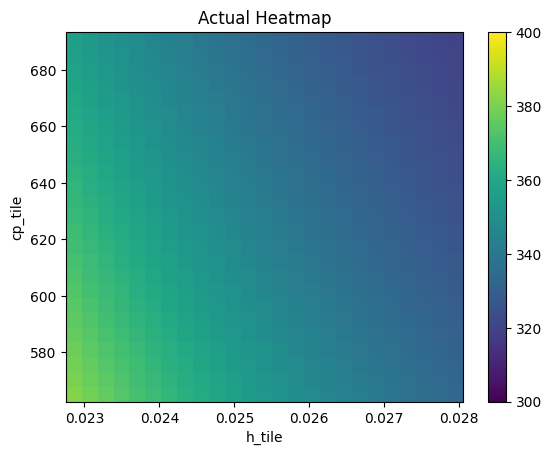

In [12]:
plot_df, var1, var2, var1_seq, var2_seq = get_heatmap('h_tile','cp_tile')

# next, cp_Ti, k_Ti (useless)

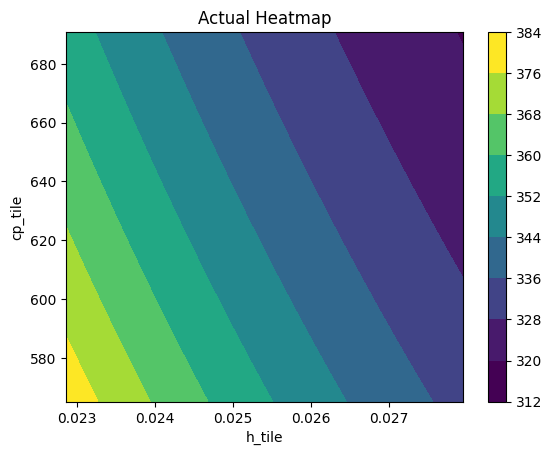

In [13]:
  # -----
  # Graphing
  # -----

import matplotlib.pyplot as plt

x1_grid = plot_df[var1].to_numpy().reshape((len(var1_seq),len(var2_seq)))
x2_grid = plot_df[var2].to_numpy().reshape((len(var1_seq),len(var2_seq)))
f_grid = plot_df['T_Ti'].to_numpy().reshape((len(var1_seq),len(var2_seq)))

#plt.pcolormesh(x1_grid,x2_grid,f_grid)
plt.contourf(x1_grid,x2_grid,f_grid)

plt.xlabel(var1)
plt.ylabel(var2)

plt.colorbar()
plt.clim(320,380)

plt.title('Actual Heatmap')

plt.show()

In [14]:
expand_grid({'x': (0,1,2), 'y': (3,4,5)})

,x,y
0,0,3
1,0,4
2,0,5
3,1,3
4,1,4
5,1,5
6,2,3
7,2,4
8,2,5


In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

plot_df_scaled = scaler.fit_transform(plot_df)

plot_df_scaled = pd.DataFrame(plot_df_scaled)

list(plot_df_scaled.loc[0])

[0.0,
 -1.6641005886756872,
 0.0,
 0.0,
 0.0,
 -1.6641005886756877,
 0.0,
 2.7755575615628914e-17,
 0.0,
 1.1102230246251565e-16,
 0.0,
 0.0,
 0.0,
 0.0,
 2.677744659618482]

# Making the predicted heatmap



## *Models and import statements*

In [16]:
# Set up
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, ExpSineSquared, DotProduct, Matern, WhiteKernel
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures as PF
from IPython.display import clear_output
from datetime import datetime as dt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

constant = 1
kernel = constant * RBF(length_scale= 1.0 , length_scale_bounds=(1e-3, 1e3)) #+ WhiteKernel(noise_level=0.5)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y = True)

rfr = RFR(n_estimators = 100)

lasso = Lasso(alpha = 0.25)

linear = LinearRegression()


## ML Predicted Heatmap

In [17]:
def get_heatmap_pred(var1,var2,model,s):
  """
  This function takes two variables in the run_model equation and creates a heatmap grid from -10% to +10% of the baseline value.

  Example:
  var1 = h_tile
  var2 = cp_tile
  model = gpr

  """
  n = 25 # n x n grid

  var1 = str(var1)
  print('var1 = ' + var1)

  var2 = str(var2)
  print('var2 = ' + var2)

  print('model = ' + str(model))

  # -----
  # Setting the mean value of var1 and var2
  # -----

  base_var1 = 0
  base_var2 = 0

  if var1 == 't_final':
    base_var1 = 60
  elif var1 == 'h_tile':
    base_var1 = 0.0254
  elif var1 == 'h_Ti':
    base_var1 = 0.00015
  elif var1 == 'rho_tile':
    base_var1 = 144
  elif var1 == 'rho_Ti':
    base_var1 = 4540
  elif var1 == 'cp_tile':
    base_var1 = 628
  elif var1 == 'cp_Ti':
    base_var1 = 460
  elif var1 == 'k_tile':
    base_var1 = 0.126
  elif var1 == 'k_Ti':
    base_var1 = 7.1
  elif var1 == 'emissivity':
    base_var1 = 0.8
  elif var1 == 'M_inf':
    base_var1 = 0.126
  elif var1 == 'p_inf':
    base_var1 = 2736.0
  elif var1 == 'T_inf':
    base_var1 = 284.0
  elif var1 == 'fudge_factor':
    base_var1 = 1.0
  else:
    print("Error: var1 isn't an input")

  print('base_var1 = ' + str(base_var1))

  if var1 == var2:
    print("Error: var1 = var2")
  elif var2 == 't_final':
    base_var2 = 60
  elif var2 == 'h_tile':
    base_var2 = 0.0254
  elif var2 == 'h_Ti':
    base_var2 = 0.00015
  elif var2 == 'rho_tile':
    base_var2 = 144
  elif var2 == 'rho_Ti':
    base_var2 = 4540
  elif var2 == 'cp_tile':
    base_var2 = 628
  elif var2 == 'cp_Ti':
    base_var2 = 460
  elif var2 == 'k_tile':
    base_var2 = 0.126
  elif var2 == 'k_Ti':
    base_var2 = 7.1
  elif var2 == 'emissivity':
    base_var2 = 0.8
  elif var2 == 'M_inf':
    base_var2 = 0.126
  elif var2 == 'p_inf':
    base_var2 = 2736.0
  elif var2 == 'T_inf':
    base_var2 = 284.0
  elif var2 == 'fudge_factor':
    base_var2 = 1.0
  else:
    print("Error: var2 isn't an input")

  print('base_var2 = ' + str(base_var2))

  # -----
  # Creating the grid bounds
  # -----

  lowerbound_1, upperbound_1 = ten_percent_bounds(base_var1)

  print('lowerbound_1 = ' + str(lowerbound_1) + ' | upperbound_1 = ' + str(upperbound_1))

  lowerbound_2, upperbound_2 = ten_percent_bounds(base_var2)

  print('lowerbound_2 = ' + str(lowerbound_2) + ' | upperbound_2 = ' + str(upperbound_2))

  # -----
  # Creating the gridspace
  # -----

  var1_seq = np.linspace(lowerbound_1,upperbound_1,n)

  var2_seq = np.linspace(lowerbound_2,upperbound_2,n)

  plot_df = expand_grid({var1: var1_seq, var2: var2_seq}) # need to make it a new name

  print(plot_df)

  # -----
  # Removing X1 and X2 Columns
  # -----

  var_list = ['t_final','h_tile','h_Ti','rho_tile','rho_Ti','cp_tile','cp_Ti','k_tile','k_Ti','emissivity', 'M_inf', 'p_inf', 'T_inf', 'fudge_factor']

  #print("# of constant variables = "+str(len(var_list)))

  if var1 in var_list:
    var_list.remove(var1)
    #print("# of constant variables = "+str(len(var_list)))

  if var2 in var_list:
    var_list.remove(var2)
    #print("# of constant variables = "+str(len(var_list)))

  # -----
  # Adding Constant Columns
  # -----

  for var in var_list: # remaining variables

    #plot_df[var] = 0 # create a blank column with its title

    if var == 't_final':
      plot_df[var] = 60
    elif var == 'h_tile':
      plot_df[var] = 0.0254
    elif var == 'h_Ti':
      plot_df[var] = 0.00015
    elif var == 'rho_tile':
      plot_df[var] = 144
    elif var == 'rho_Ti':
      plot_df[var] = 4540
    elif var == 'cp_tile':
      plot_df[var] = 628
    elif var == 'cp_Ti':
      plot_df[var] = 460
    elif var == 'k_tile':
      plot_df[var] = 0.126
    elif var == 'k_Ti':
      plot_df[var] = 7.1
    elif var == 'emissivity':
      plot_df[var] = 0.8
    elif var == 'M_inf':
      plot_df[var] = 5
    elif var == 'p_inf':
      plot_df[var] = 2736.0
    elif var == 'T_inf':
      plot_df[var] = 284.0
    elif var == 'fudge_factor':
      plot_df[var] = 1.0

  # -----
  # Reordering Columns
  # -----

  cols = plot_df.columns.tolist()

  cols = ['t_final','h_tile','h_Ti','rho_tile','rho_Ti','cp_tile','cp_Ti','k_tile','k_Ti','emissivity', 'M_inf', 'p_inf', 'T_inf', 'fudge_factor']

  plot_df = plot_df[cols]

  # -----
  # Model Fitting
  # -----

  from sklearn.preprocessing import StandardScaler
  scaler = StandardScaler()

  plot_df_scaled = scaler.fit_transform(plot_df)
  plot_df_scaled = pd.DataFrame(plot_df_scaled)

  # -----
  # Training ML model
  # -----

  LHS_url = 'https://raw.githubusercontent.com/benkim1226/footballdata/master/LHS_complete.csv'
  LHS_data = pd.read_csv(LHS_url, index_col = 0)
  LHS_data = LHS_data.reset_index()

  scaled_LHS = scaler.fit_transform(LHS_data)
  scaled_LHS = pd.DataFrame(scaled_LHS)

  indexes = random.sample(range(0, len(scaled_LHS)), s) # change s

  sample_data = scaled_LHS.loc[indexes]
  sample_y = LHS_data['simulation_values'].loc[indexes]

  X = sample_data.loc[:,0:13]
  y = sample_y

  print("Train test splitting")

  from sklearn.model_selection import train_test_split

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  print("Train test splitted")

  # -----
  # GPR
  # -----

  print("Fitting model")

  model.fit(X_train, y_train)

  print("Model fitted")

  model_MAE = mean_absolute_error(y_test, model.predict(X_test))
  model_MAE = round(model_MAE,2)

  print("Model MAE = "+str(model_MAE)) # is the model good?

  values = plot_df_scaled
  predicted_values = model.predict(values)
  plot_df['Predicted T_Ti'] = predicted_values

  print(plot_df.head())

  # -----
  # Graphing
  # -----

  import matplotlib.pyplot as plt

  x1_grid = plot_df[var1].to_numpy().reshape((len(var1_seq),len(var2_seq)))
  x2_grid = plot_df[var2].to_numpy().reshape((len(var1_seq),len(var2_seq)))
  f_grid = plot_df['Predicted T_Ti'].to_numpy().reshape((len(var1_seq),len(var2_seq)))

  #plt.pcolormesh(x1_grid,x2_grid,f_grid)
  plt.contourf(x1_grid,x2_grid,f_grid)

  plt.xlabel(var1)
  plt.ylabel(var2)

  plt.colorbar()
  plt.clim(320,384)

  plt.title('Predicted Heatmap (s=' +str(s)+', mae='+str(model_MAE)+')')

  plt.show()

  return plot_df, var1, var2, var1_seq, var2_seq # save the output!

## Executing Function

var1 = h_tile
var2 = cp_tile
model = Lasso(alpha=0.25)
base_var1 = 0.0254
base_var2 = 628
lowerbound_1 = 0.02286 | upperbound_1 = 0.02794
lowerbound_2 = 565.2 | upperbound_2 = 690.8
      h_tile     cp_tile
0    0.02286  565.200000
1    0.02286  570.433333
2    0.02286  575.666667
3    0.02286  580.900000
4    0.02286  586.133333
..       ...         ...
620  0.02794  669.866667
621  0.02794  675.100000
622  0.02794  680.333333
623  0.02794  685.566667
624  0.02794  690.800000

[625 rows x 2 columns]
Train test splitting
Train test splitted
Fitting model
Model fitted
Model MAE = 2.3
   t_final   h_tile     h_Ti  rho_tile  rho_Ti     cp_tile  cp_Ti  k_tile  \
0       60  0.02286  0.00015       144    4540  565.200000    460   0.126   
1       60  0.02286  0.00015       144    4540  570.433333    460   0.126   
2       60  0.02286  0.00015       144    4540  575.666667    460   0.126   
3       60  0.02286  0.00015       144    4540  580.900000    460   0.126   
4       60  0.02286  0.00

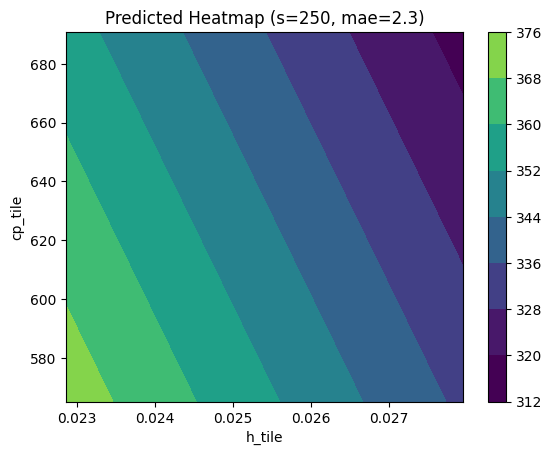

In [18]:
plot_df_pred, var1_pred, var2_pred, var1_seq_pred, var2_seq_pred = get_heatmap_pred('h_tile', 'cp_tile', lasso, 250)